In [57]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [ ]:
class FEM:
    def __init__(self, x0, xN, steps):
        self.x0 = x0
        self.xN = xN
        self.steps = steps
        self.h = (xN - x0) / steps


def hat(x, i: int, h):
    x_i = h * i

    y = np.maximum(-np.abs(x - x_i) / h + 1, 0)
    return y


def a_ij(i, j, h):
    if i == j:
        return 2 / h
    elif np.abs(i - j) == 1:
        return -1 / h
    else:
        return 0


def b_j(j, h, func, a, b):
    def f(x):
        return func(x) * hat(x, j, h)

    y, abs_err = sp.integrate.quad(f, a, b)
    return y


def constr_f(vec, x, h):
    y = np.zeros_like(x)
    for i, val in enumerate(vec):
        y += val * hat(x, i + 1, h)

    return y


def b_j_1(j, h):
    return h


def b_j_2(j, h):
    return 2 * hat(1 / 2, j, h)


def b_j_3(j, h):
    # return 2 * np.sin(np.pi * h * j) * (1 - np.cos(np.pi * h))/np.pi/h
    return (
        -np.sin(h * np.pi * (j - 1))
        + np.sin(h * np.pi * (j + 1))
        - 2 * np.sin(h * np.pi * j)
    ) / (h * np.pi**2)


def f1(x):
    return -0.5 * (x - 0.5) ** 2 + 0.125


def f1pp(x):
    return np.ones_like(x)


def f2(x):
    return 1 - np.abs(2 * (x - 0.5))


def f2pp(x):
    y = np.zeros_like(x)
    y[np.abs(x - 0.5) < 1e-2] = 1e20
    return y


def f3(x):
    return (np.sin(np.pi * x)) / np.pi**2


def f3pp(x):
    return -np.sin(np.pi * x)


funcs = {"f1": (f1, f1pp, b_j_1), "f2": (f2, f2pp, b_j_2), "f3": (f3, f3pp, b_j_3)}


def l2_err(a, b, h):
    return np.sqrt(np.sum((a - b) ** 2) * h)

[[ 20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20.]]
1.5263333545166298
L2 Error: 15.3


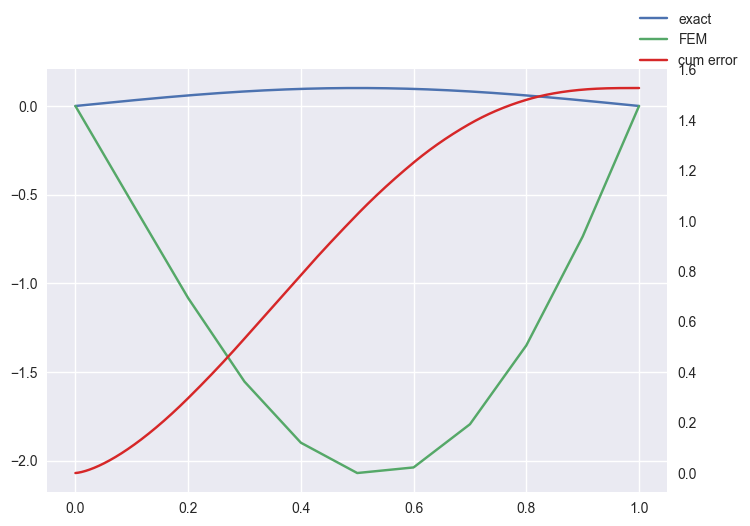

In [ ]:
x0, xN = 0, 1
N = 10
h = (xN - x0) / (N)


u_f, u_fpp, u_b = funcs["f3"]

a = np.array([[a_ij(i, j, h) for j in range(1, N)] for i in range(1, N)])

b = np.array([u_b(i, h) for i in range(1, N)])
# b = np.array([b_j(i, h, u_fpp, x0, xN) for i in range(1, N)])

x = np.linalg.solve(a, b)

fig, ax = plt.subplots()

fine_x = np.linspace(x0, xN, num=1000)
u_anal = u_f(fine_x)
ax.plot(fine_x, u_anal, label="exact")

x_grid = np.linspace(x0, xN, num=N + 1)
u_num_corse = np.pad(x, 1, "constant", constant_values=0)
ax.plot(x_grid, u_num_corse, label="FEM")

u_num_fine = constr_f(x, fine_x, h)
# ax.plot(fine_x, u_num_fine)

print(a)

error = np.sqrt(
    np.cumsum((u_anal - u_num_fine) ** 2) * (fine_x[1] - fine_x[0])
)  # approximate integral by sum
print(error[-1])
l2_error = l2_err(u_anal, u_num_fine, h)
print(f"L2 Error: {l2_error:#.3}")

ax2 = ax.twinx()
ax2.plot(fine_x, error, color="tab:red", label="cum error")
ax2.grid(False)
_ = fig.legend()

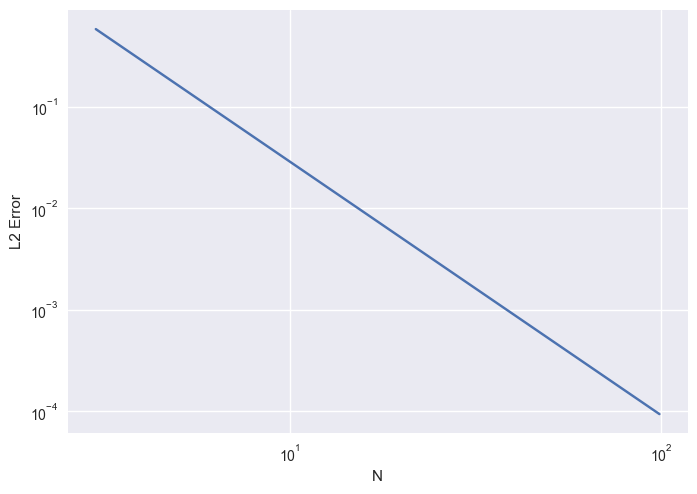

In [60]:
# Over N
u_f, u_fpp, u_b = funcs["f1"]


x0, xN = 0, 1
fine_x = np.linspace(x0, xN, num=10000)
u_anal = u_f(fine_x)

temp = []
ns = np.arange(3, 100)

fig, ax = plt.subplots()

for N in ns:

    h = (xN - x0) / (N)

    a = np.array([[a_ij(i, j, h) for j in range(1, N)] for i in range(1, N)])
    b = np.array([u_b(i, h) for i in range(1, N)])
    # b = np.array([b_j(i, h, used_fpp, x0, xN) for i in range(1, N)])
    x = np.linalg.solve(a, b)

    u_num_fine = constr_f(x, fine_x, h)
    l2_error = l2_err(u_num_fine, u_anal, h)
    temp.append(l2_error)

errors = np.array(temp)


ax.plot(ns, errors)

ax.set_xlabel("N")
ax.set_ylabel("L2 Error")

ax.set_xscale("log")
ax.set_yscale("log")